# Identifying Watercourses susceptible to re-meandering

In [ ]:
pip install folium matplotlib mapclassify palettable descartes pysal contextily matplotlib_scalebar geopandas

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
#Import packages
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
from pysal.viz import mapclassify
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify
import matplotlib.patches as mpatches
import requests
import datetime
import json
import math
from shapely import wkt
from scipy.stats import gaussian_kde
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from pysal.lib import weights
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# Import Files

In [ ]:
#Load Clipped Buffer Watercourses file
Clip_Watercourses_Buffer = gpd.read_file('Clip_Watercourses_Buffer.shp')
Clip_Watercourses_Buffer.rename(columns={'id': 'FID'}, inplace=True)
Clip_Watercourses_Buffer.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53310 entries, 0 to 53309
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       53310 non-null  int64   
 1   geometry  53310 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 833.1 KB


In [ ]:
#Load Clipped Watercourses file (not buffered)
Clip_Watercourses = gpd.read_file('Clip_Watercourses.shp')
Clip_Watercourses.rename(columns={'id': 'FID'}, inplace=True)
Clip_Watercourses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53310 entries, 0 to 53309
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       53310 non-null  float64 
 1   type      53310 non-null  object  
 2   geometry  53310 non-null  geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 1.2+ MB


In [ ]:
#Get the range of FID values in both datasets to check they match
print(f"Min and Max FID in Clip_Watercourses: {Clip_Watercourses['FID'].min()}, {Clip_Watercourses['FID'].max()}")
print(f"Min and Max FID in Clip_Watercourses_Buffer: {Clip_Watercourses_Buffer['FID'].min()}, {Clip_Watercourses_Buffer['FID'].max()}")

Min and Max FID in Clip_Watercourses: 106.0, 2523847.0
Min and Max FID in Clip_Watercourses_Buffer: 0, 53309


In [ ]:
#Load region file
Region = gpd.read_file('filt_counties2.shp')
Region.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CTYUA23CD   6 non-null      object  
 1   CTYUA23NM   6 non-null      object  
 2   CTYUA23NMW  0 non-null      object  
 3   BNG_E       6 non-null      int64   
 4   BNG_N       6 non-null      int64   
 5   LONG        6 non-null      float64 
 6   LAT         6 non-null      float64 
 7   GlobalID    6 non-null      object  
 8   geometry    6 non-null      geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 564.0+ bytes


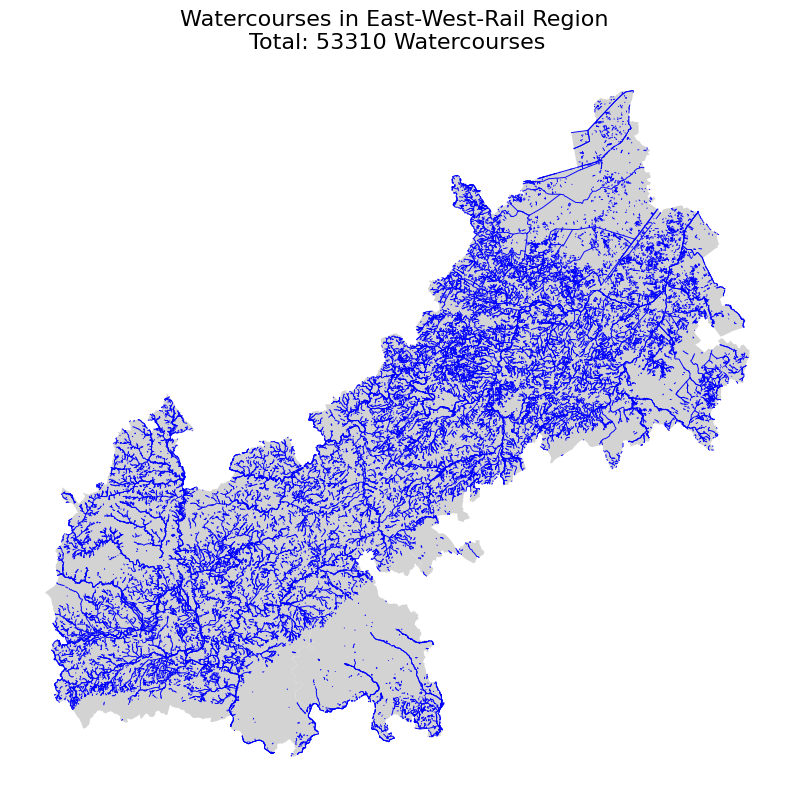

In [ ]:
#Map out the initial, full map of watercourses
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
num_lines = len(Clip_Watercourses_Buffer) #calculate number of watercourses
ax.set_title(f'Watercourses in East-West-Rail Region \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Land Cover

The watercourses that are in urban and unsuitable land covers are eliminated.

In [ ]:
land_cover_clip = gpd.read_file('Clip_Land_Cover.shp')

In [ ]:
land_cover_clip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 245123 entries, 0 to 245122
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   _conf       245123 non-null  object  
 1   _hist       245123 non-null  object  
 2   _mode       245123 non-null  object  
 3   _n          245123 non-null  object  
 4   _purity     245123 non-null  object  
 5   _stdev      245123 non-null  object  
 6   _agg        245123 non-null  object  
 7   gid         245123 non-null  object  
 8   Habitat_ty  0 non-null       object  
 9   geometry    245123 non-null  geometry
dtypes: geometry(1), object(9)
memory usage: 18.7+ MB


In [ ]:
land_cover_clip['_mode'] = land_cover_clip['_mode'].astype(int)

In [ ]:
land_cover_dict = {
   1: 'Broadleaved woodland',
   2: 'Coniferous Woodland',
   3: 'Arable and Horticulture',
   4: 'Improved Grassland',
   5: 'Neutral Grassland',
   6: 'Calcareous Grassland',
   7: 'Acid grassland',
   8: 'Fen, Marsh and Swamp',
   9: 'Heather',
   10: 'Heather grassland',
   11: 'Bog',
   12: 'Inland Rock',
   13: 'Saltwater',
   14: 'Freshwater',
   15: 'Supralittoral Rock',
   16: 'Supralittoral Sediment',
   17: 'Littoral Rock',
   18: 'Littoral sediment',
   19: 'Saltmarsh',
   20: 'Urban',
   21: 'Suburban'
}
land_cover_clip['_mode'] = land_cover_clip['_mode'].map(land_cover_dict)

In [ ]:
land_type = land_cover_clip[['_mode', 'geometry']]

In [ ]:
land_type_weights = {"Broadleaved woodland": 0,"Coniferous Woodland": 0, "Arable and Horticulture": 0.5,"Improved Grassland": 1,"Neutral Grassland": 1,"Calcareous Grassland": 1, 'Acid grassland': 1, 'Fen, Marsh and Swamp': 1, 'Heather': 0, 'Heather grassland': 0, 'Bog': 1, 'Inland Rock': 0, 'Saltwater':0, 'Freshwater': 1, 'Supralittoral Rock': 0, 'Supralittoral Sediment': 0, 'Littoral Rock': 0, 'Littoral sediment': 0, 'Saltmarsh': 0, 'Urban': 0, 'Suburban':0,}

In [ ]:
land_type["_mode_weight"] = land_type["_mode"].map(land_type_weights)
land_type.head()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


_mode                                           geometry  \
0          Freshwater  POLYGON ((473019.003 173961.111, 473092.2 1739...   
1          Freshwater  POLYGON ((473183.728 173936.793, 473267.2 1739...   
2  Improved Grassland  POLYGON ((473039.1 174124.752, 473080.27 17409...   
3          Freshwater  POLYGON ((473711.753 174172.138, 473713.563 17...   
4          Freshwater  POLYGON ((473711.753 174172.138, 473721.261 17...   

   _mode_weight  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0

In [ ]:
land_type.to_file("land_type_weighted.shp")

<ipython-input-15-b7beb57490b7>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  land_type.to_file("land_type_weighted.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: '_mode_weight' to '_mode_weig'
  ogr_write(


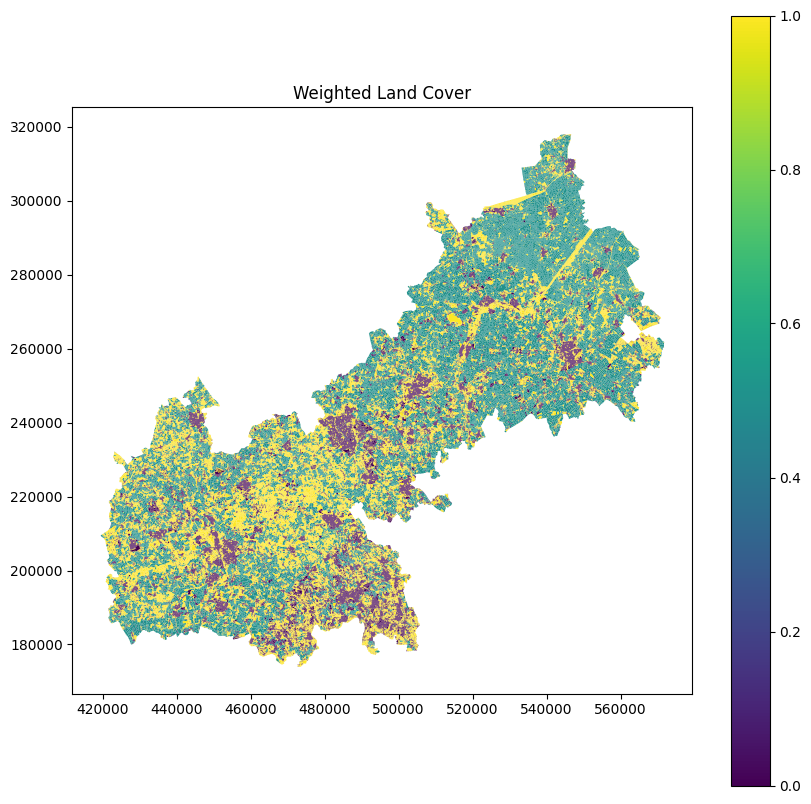

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
land_type.plot(column='_mode_weight', legend=True, ax=ax)
plt.title("Weighted Land Cover")
plt.show()

In [ ]:
land_type_filt = land_type[land_type["_mode_weight"] > 0.5]

In [ ]:
intersect_land_water = gpd.sjoin(Clip_Watercourses_Buffer, land_type_filt, how="inner", predicate='intersects')
intersect_land_water.head()

FID                                           geometry  index_right  \
0    0  POLYGON ((434029.645 187012.301, 434027.885 18...       150914   
0    0  POLYGON ((434029.645 187012.301, 434027.885 18...       150902   
1    1  POLYGON ((434260.766 186994.852, 434251.172 18...       150902   
1    1  POLYGON ((434260.766 186994.852, 434251.172 18...       150917   
2    2  POLYGON ((432590.293 187357.004, 432589.546 18...       150681   

                _mode  _mode_weight  
0  Improved Grassland           1.0  
0  Improved Grassland           1.0  
1  Improved Grassland           1.0  
1  Improved Grassland           1.0  
2  Improved Grassland           1.0

In [ ]:
intersect_land_water.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 209429 entries, 0 to 53309
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   FID           209429 non-null  int64   
 1   geometry      209429 non-null  geometry
 2   index_right   209429 non-null  int64   
 3   _mode         209429 non-null  object  
 4   _mode_weight  209429 non-null  float64 
dtypes: float64(1), geometry(1), int64(2), object(1)
memory usage: 9.6+ MB


In [ ]:
print("Number of unique FIDs in intersect_land_water:", intersect_land_water['FID'].nunique())

Number of unique FIDs in intersect_land_water: 44462


**Create Scoring for Matrix**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Land Cover
#If watercourse is in suitable land cover (aka is in the intersect dataset) = 1
#If watercourse is in unsuitable land cover (aka is not in intersect dataset) = 0
#Create set of FIDs from the intersect
intersect_fids = set(intersect_land_water['FID'])
#Assign score of 1 if the FIDs is in intersect, otherwise 0
Clip_Watercourses['Score_Land_Cover'] = Clip_Watercourses['FID'].apply(lambda x: 1 if x in intersect_fids else 0)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

**Visualization of elimination of watercourses**

In [ ]:
#Keep only the watercourses near the filterered land covers
#So keep only the watercourses in the intersect dataset
Watercourses_Buffer_cleaned = Clip_Watercourses_Buffer[Clip_Watercourses_Buffer['FID'].isin(intersect_land_water['FID'])]
#Check that there are now 44462 watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 44462 entries, 0 to 53309
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       44462 non-null  int64   
 1   geometry  44462 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.0 MB


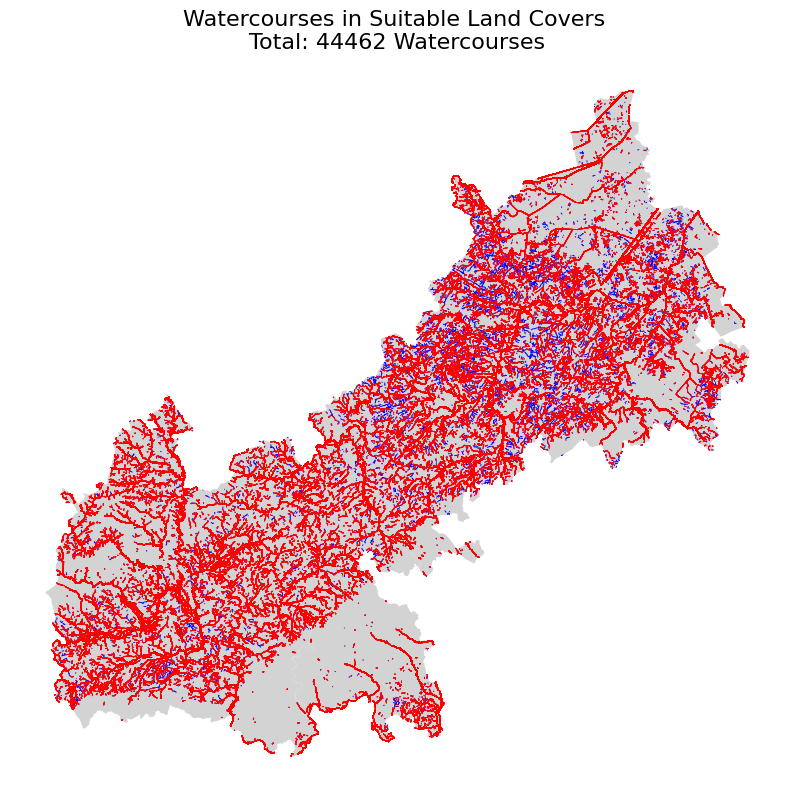

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
intersect_land_water.plot(ax=ax, color='red')
num_lines = intersect_land_water['FID'].nunique()
ax.set_title(f'Watercourses in Suitable Land Covers \nTotal: {num_lines} Watercourses', fontsize=16)
#Add the legend
ax.set_axis_off()
plt.show()

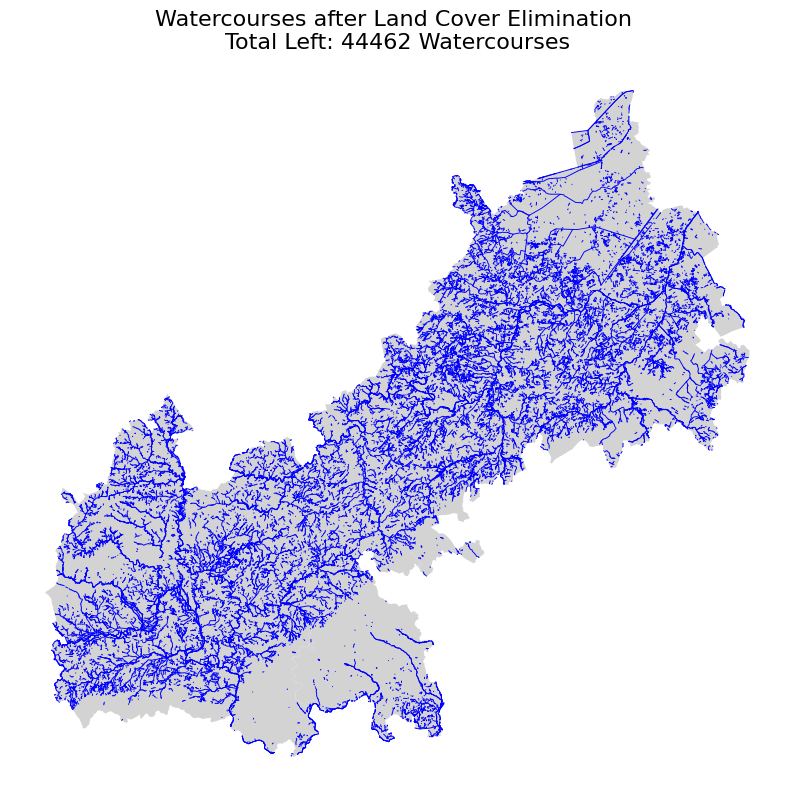

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Land Cover Elimination \nTotal Left: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Agricultural Land Classification

Watercourses in high value agricultural land classification are eliminated.

In [ ]:
agriculture = gpd.read_file('Clip_Agri_Land.shp')
agriculture.head()

GEOGEXT        AREA ALC_GRADE   PERIMETER  \
0      67   1858.2545   Grade 4   89297.667   
1      67  14969.2032   Grade 3  329089.973   
2      67   5800.4647   Grade 2  260247.854   
3      67   2538.2289   Grade 2  117943.773   
4      67  20985.0756   Grade 3  288803.640   

                                            geometry  
0  POLYGON ((428914.312 180923.406, 428918.902 18...  
1  MULTIPOLYGON (((433469.767 183690.699, 433571....  
2  MULTIPOLYGON (((429538.301 182415.41, 429575.6...  
3  MULTIPOLYGON (((425363 184109.703, 425340.688 ...  
4  MULTIPOLYGON (((428256.312 180187.297, 428254....

In [ ]:
agri_weights = {"Grade 1": 1,"Grade 2": 2, "Grade 3": 3,"Grade 4": 4,"Grade 5": 5,}

In [ ]:
agriculture['ALC_GRADE'].unique()

array(['Grade 4', 'Grade 3', 'Grade 2', 'Urban', 'Non Agricultural',
       'Grade 1', 'Grade 5'], dtype=object)

In [ ]:
agriculture["grade_weight"] = agriculture["ALC_GRADE"].map(agri_weights)
agriculture.head()

GEOGEXT        AREA ALC_GRADE   PERIMETER  \
0      67   1858.2545   Grade 4   89297.667   
1      67  14969.2032   Grade 3  329089.973   
2      67   5800.4647   Grade 2  260247.854   
3      67   2538.2289   Grade 2  117943.773   
4      67  20985.0756   Grade 3  288803.640   

                                            geometry  grade_weight  
0  POLYGON ((428914.312 180923.406, 428918.902 18...           4.0  
1  MULTIPOLYGON (((433469.767 183690.699, 433571....           3.0  
2  MULTIPOLYGON (((429538.301 182415.41, 429575.6...           2.0  
3  MULTIPOLYGON (((425363 184109.703, 425340.688 ...           2.0  
4  MULTIPOLYGON (((428256.312 180187.297, 428254....           3.0

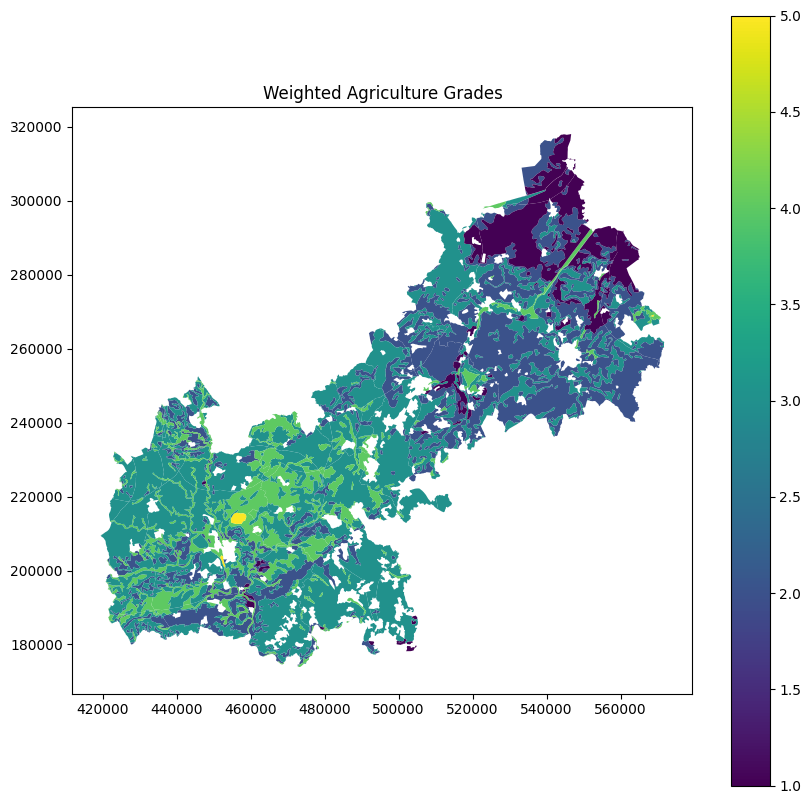

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
agriculture.plot(column='grade_weight', legend=True, ax=ax)
plt.title("Weighted Agriculture Grades")
plt.show()

In [ ]:
agriculture_filt = agriculture[agriculture["grade_weight"] > 3]

In [ ]:
intersect_agri_water = gpd.sjoin(Clip_Watercourses_Buffer, agriculture_filt, how="inner", predicate='intersects')
intersect_agri_water.head()

FID                                           geometry  index_right  \
23   23  POLYGON ((433364.877 187949.973, 433403.423 18...           19   
28   28  POLYGON ((430713.361 188030.944, 430717.403 18...           19   
30   30  POLYGON ((431351.903 188273.867, 431353.662 18...           19   
31   31  POLYGON ((430946.06 188367.987, 430945.874 188...           19   
33   33  POLYGON ((431136.924 188590.181, 431141.69 188...           19   

   GEOGEXT       AREA ALC_GRADE  PERIMETER  grade_weight  
23      67  1283.3032   Grade 4  63977.735           4.0  
28      67  1283.3032   Grade 4  63977.735           4.0  
30      67  1283.3032   Grade 4  63977.735           4.0  
31      67  1283.3032   Grade 4  63977.735           4.0  
33      67  1283.3032   Grade 4  63977.735           4.0

In [ ]:
print("Number of unique FIDs in intersect_agri_water:", intersect_agri_water['FID'].nunique())

Number of unique FIDs in intersect_agri_water: 11875


In [ ]:
agriculture.to_file("agriculture.shp")

<ipython-input-33-48d8fa405629>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  agriculture.to_file("agriculture.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'grade_weight' to 'grade_weig'
  ogr_write(


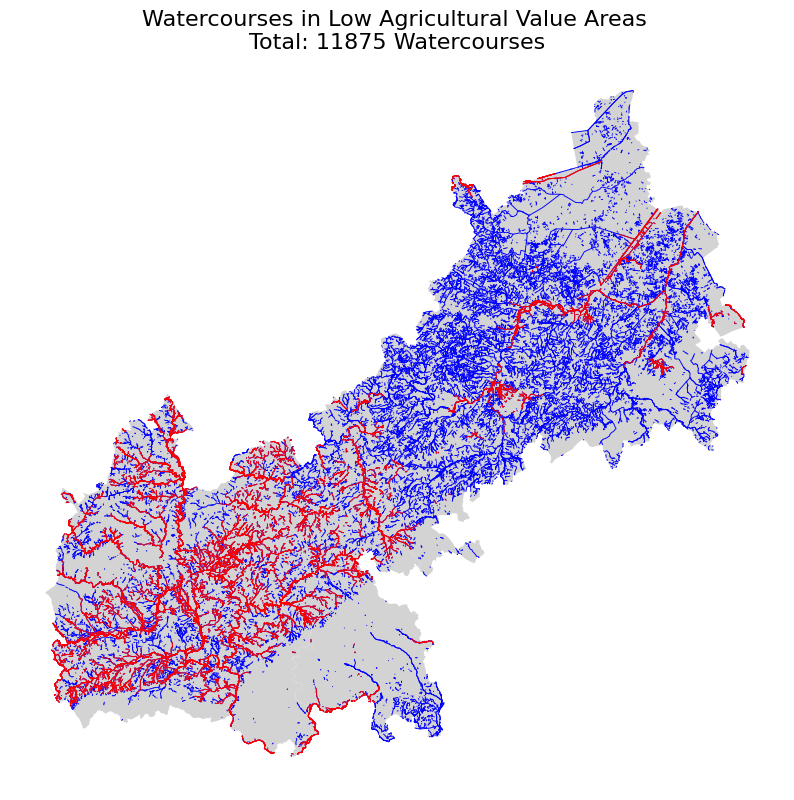

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
intersect_agri_water.plot(ax=ax, color='red')
num_lines = intersect_agri_water['FID'].nunique()
ax.set_title(f'Watercourses in Low Agricultural Value Areas \nTotal: {num_lines} Watercourses', fontsize=16)
#Add the legend
ax.set_axis_off()
plt.show()

**Create Scoring for Agricultural Value**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Agricultural Value
#If watercourse is in low agri value (aka is in the intersect dataset) = 1
#If watercourse is in high agri value (aka is not in intersect dataset) = 0
#Create set of FIDs from the intersect
intersect_fids = set(intersect_agri_water['FID'])
#Assign score of 1 if the FIDs is in intersect, otherwise 0
Clip_Watercourses['Score_Agri_Value'] = Clip_Watercourses['FID'].apply(lambda x: 1 if x in intersect_fids else 0)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

**Create Visualization of Watercourses elimination**

In [ ]:
#Keep only the watercourses are near the filterered low value agricultural land
#So keep only the watercourses in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[Watercourses_Buffer_cleaned['FID'].isin(intersect_agri_water['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 11116 entries, 23 to 52962
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       11116 non-null  int64   
 1   geometry  11116 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 260.5 KB


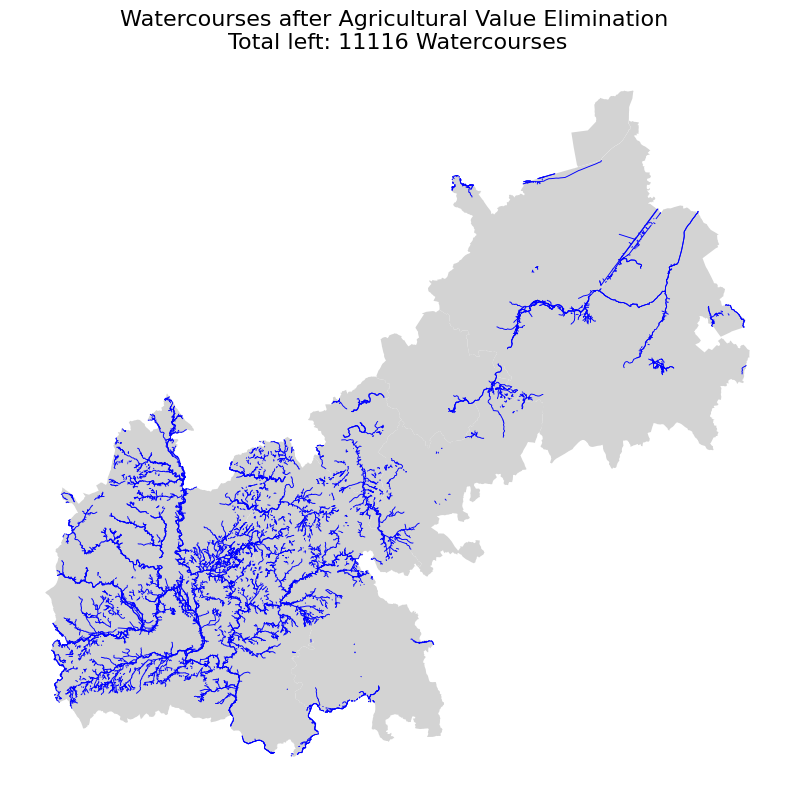

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Agricultural Value Elimination \nTotal left: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Roads (local, regional, national)

Watercourses within a 100m proximity of from roads (local, regional, national) are eliminated.

## Local Roads

In [ ]:
#Load Clipped Roads Local file
Clip_Road_Local = gpd.read_file('Clip_Road_Local.shp')
Clip_Road_Local.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 149006 entries, 0 to 149005
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   id         149006 non-null  float64 
 1   type       149006 non-null  object  
 2   name       105570 non-null  object  
 3   number     0 non-null       object  
 4   level      149006 non-null  int64   
 5   Intersect  0 non-null       float64 
 6   geometry   149006 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 8.0+ MB


In [ ]:
#Spatially join buffered watercourses and local roads into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to local roads
Intersect_water_roads_local = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Road_Local, how="inner", predicate='intersects')
Intersect_water_roads_local.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 111617 entries, 0 to 53309
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   FID          111617 non-null  int64   
 1   geometry     111617 non-null  geometry
 2   index_right  111617 non-null  int64   
 3   id           111617 non-null  float64 
 4   type         111617 non-null  object  
 5   name         65537 non-null   object  
 6   number       0 non-null       object  
 7   level        111617 non-null  int64   
 8   Intersect    0 non-null       float64 
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 8.5+ MB


In [ ]:
print("Number of unique FIDs in Intersect_water_roads_local:", Intersect_water_roads_local['FID'].nunique())

Number of unique FIDs in Intersect_water_roads_local: 29757


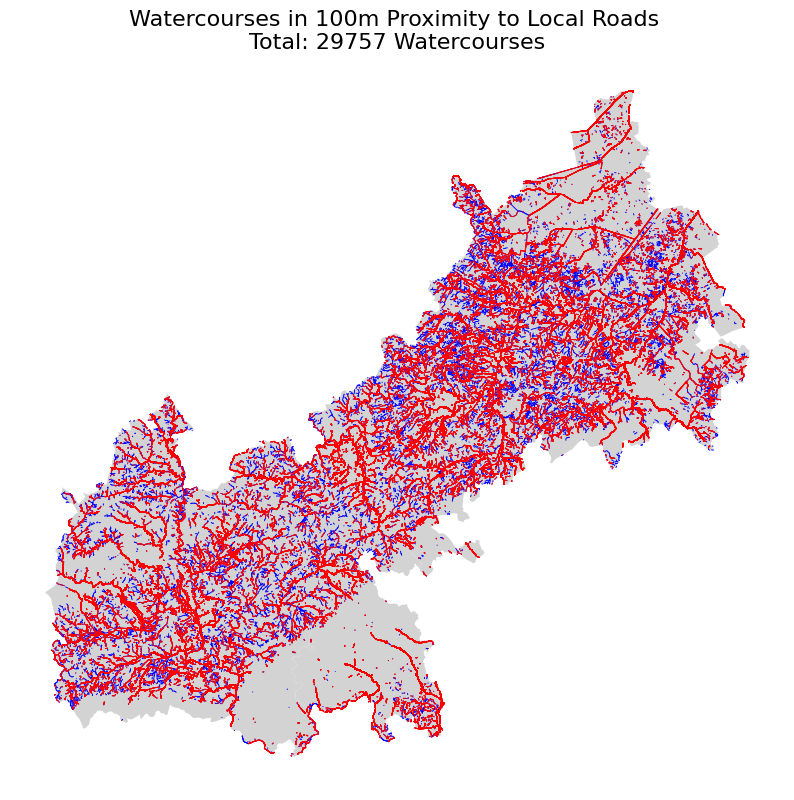

In [ ]:
#Plot watercourses near local roads
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_roads_local.plot(ax=ax, color='red')
num_lines = Intersect_water_roads_local['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to Local Roads \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create Scoring for Roads Local**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Road Local
#If watercourse near road (aka is in the intersect dataset) = 0
#If watercourse is not near road (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_roads_local['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Road_Local'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  
0                 0                 0                 1  
1                 0                 0                 1  
2                 0                 0                 1  
3                 0                 0                 1  
4                 0                 0                 1

**Create Elimination Visualization**

In [ ]:
#Keep only the watercourses not near local roads
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[~Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_roads_local['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5462 entries, 23 to 52953
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       5462 non-null   int64   
 1   geometry  5462 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 128.0 KB


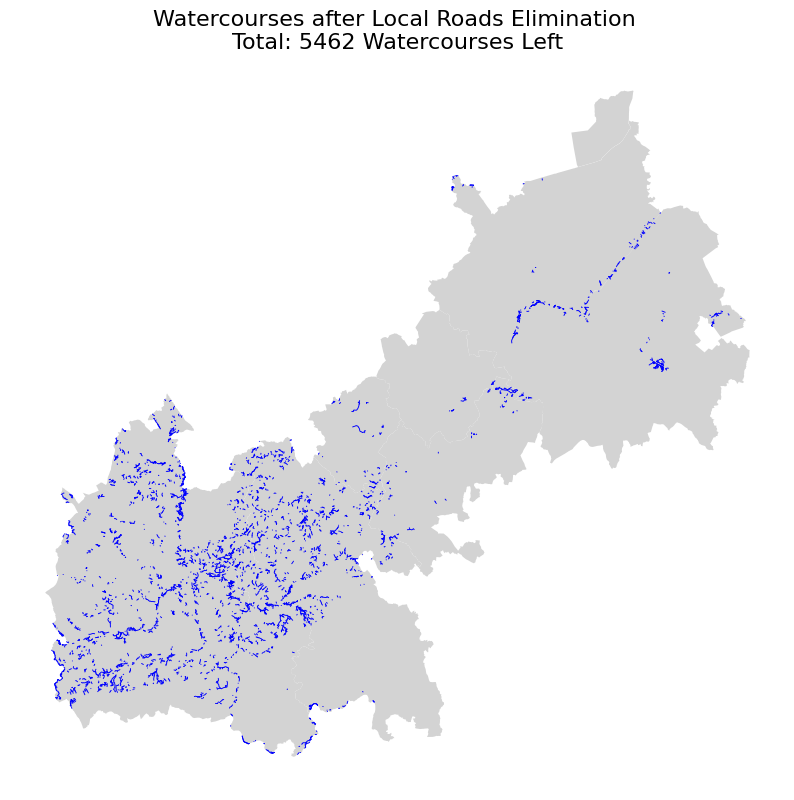

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Local Roads Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

## Regional Roads

In [ ]:
#Load Clipped Roads Regional file
Clip_Road_Regional = gpd.read_file('Clip_Road_Regional.shp')
Clip_Road_Regional.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13815 entries, 0 to 13814
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         13815 non-null  float64 
 1   type       13815 non-null  object  
 2   name       10972 non-null  object  
 3   number     13787 non-null  object  
 4   level      13787 non-null  float64 
 5   Intersect  0 non-null      float64 
 6   geometry   13815 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 755.6+ KB


In [ ]:
#Spatially join buffered watercourses and regional roads into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to regional roads
Intersect_water_roads_regional = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Road_Regional, how="inner", predicate='intersects')
Intersect_water_roads_regional.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 14403 entries, 0 to 53309
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          14403 non-null  int64   
 1   geometry     14403 non-null  geometry
 2   index_right  14403 non-null  int64   
 3   id           14403 non-null  float64 
 4   type         14403 non-null  object  
 5   name         9850 non-null   object  
 6   number       14353 non-null  object  
 7   level        14353 non-null  float64 
 8   Intersect    0 non-null      float64 
dtypes: float64(3), geometry(1), int64(2), object(3)
memory usage: 1.1+ MB


In [ ]:
print("Number of unique FIDs in Intersect_water_roads_regional:", Intersect_water_roads_regional['FID'].nunique())

Number of unique FIDs in Intersect_water_roads_regional: 5831


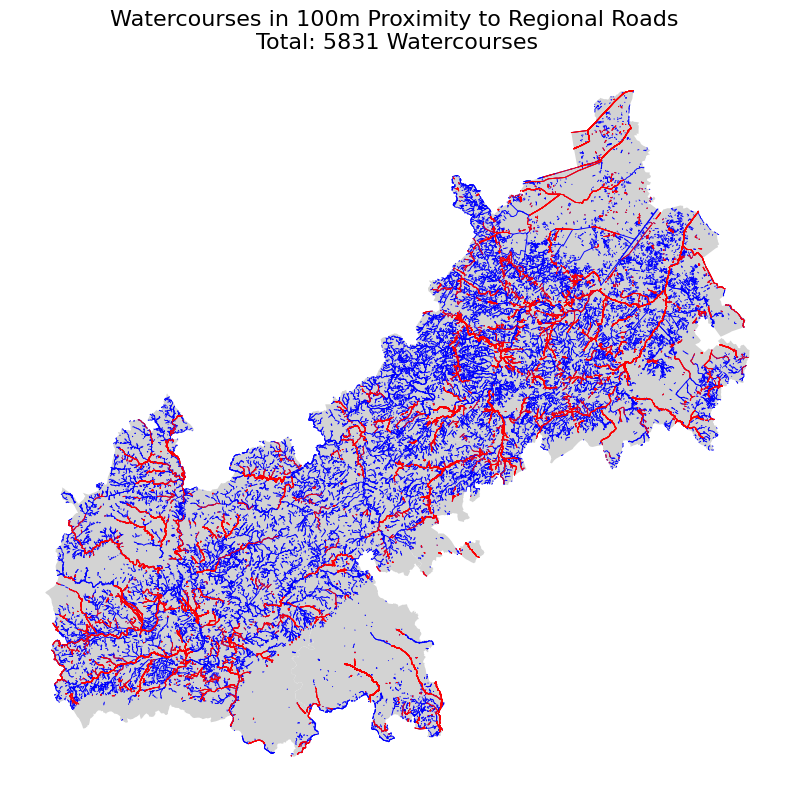

In [ ]:
#Plot watercourses near regional roads
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_roads_regional.plot(ax=ax, color='red')
num_lines = Intersect_water_roads_regional['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to Regional Roads \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create Scoring Road Regional**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Road Regional
#If watercourse near road (aka is in the intersect dataset) = 0
#If watercourse is not near road (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_roads_regional['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Road_Regional'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  
0                 0                 0                 1                    1  
1                 0                 0                 1                    1  
2                 0                 0                 1                    1  
3                 0                 0                 1                    1  
4                 0                 0                 1                    1

**Create Elimination Visualization**

In [ ]:
#Keep only the watercourses not near regional roads
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[~Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_roads_regional['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5166 entries, 23 to 52953
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       5166 non-null   int64   
 1   geometry  5166 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 121.1 KB


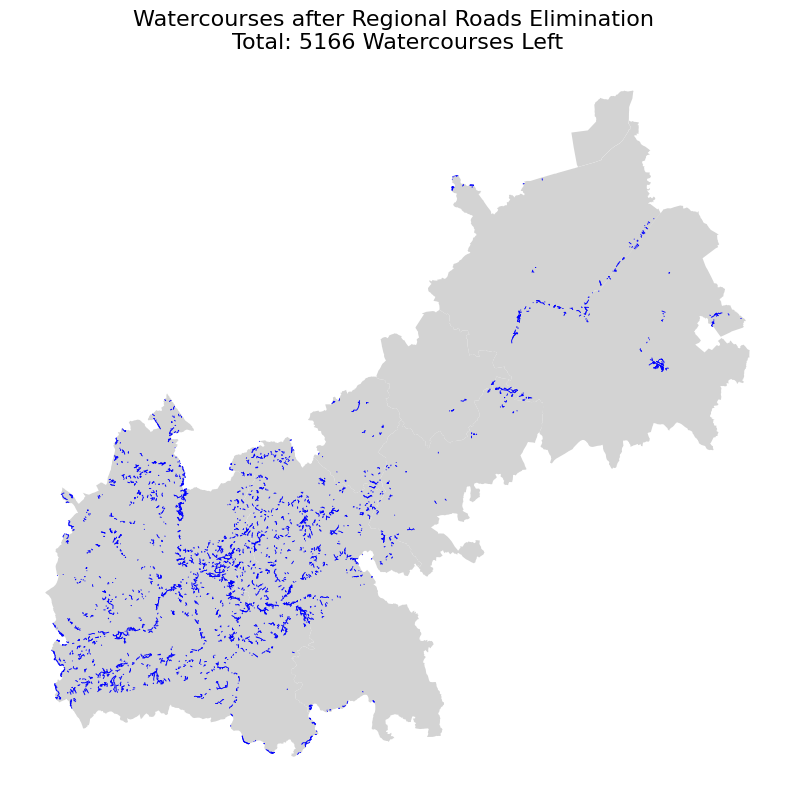

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Regional Roads Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

## National Roads

In [ ]:
#Load Clipped Roads National file
Clip_Road_National = gpd.read_file('Clip_Road_National.shp')
Clip_Road_National.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         4998 non-null   float64 
 1   type       4998 non-null   object  
 2   name       2309 non-null   object  
 3   number     4998 non-null   object  
 4   level      4998 non-null   int64   
 5   Intersect  0 non-null      float64 
 6   geometry   4998 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 273.5+ KB


In [ ]:
#Spatially join buffered watercourses and national roads into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to national roads
Intersect_water_roads_national = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Road_National, how="inner", predicate='intersects')
Intersect_water_roads_national.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7989 entries, 771 to 53243
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          7989 non-null   int64   
 1   geometry     7989 non-null   geometry
 2   index_right  7989 non-null   int64   
 3   id           7989 non-null   float64 
 4   type         7989 non-null   object  
 5   name         2921 non-null   object  
 6   number       7989 non-null   object  
 7   level        7989 non-null   int64   
 8   Intersect    0 non-null      float64 
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 624.1+ KB


In [ ]:
print("Number of unique FIDs in Intersect_water_roads_national:", Intersect_water_roads_national['FID'].nunique())

Number of unique FIDs in Intersect_water_roads_national: 3389


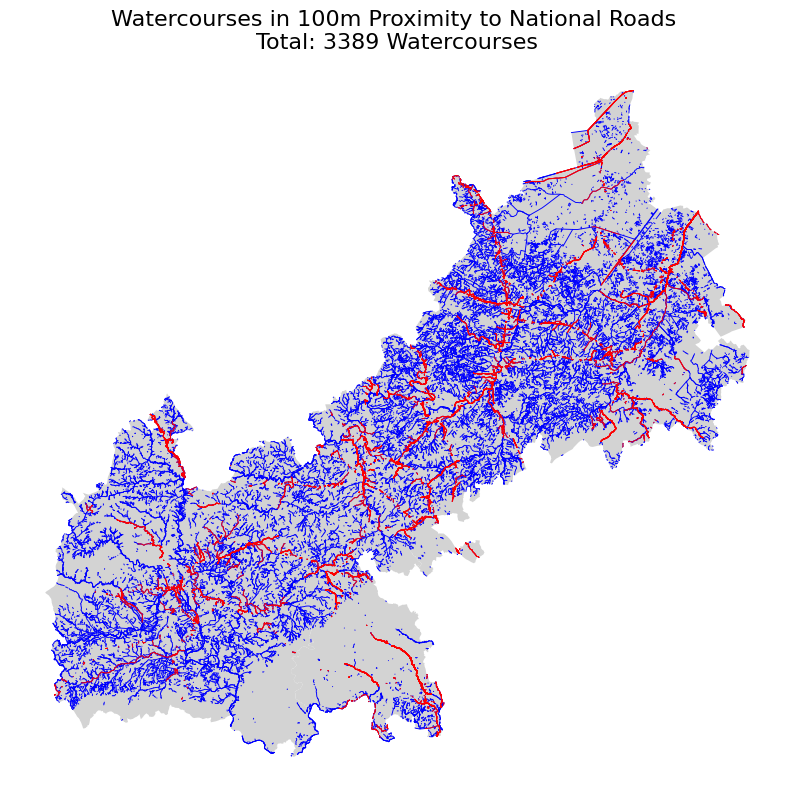

In [ ]:
#Plot watercourses near national roads
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_roads_national.plot(ax=ax, color='red')
num_lines = Intersect_water_roads_national['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to National Roads \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create Scoring Roads National**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Road National
#If watercourse near road (aka is in the intersect dataset) = 0
#If watercourse is not near road (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_roads_national ['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Road_National'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1

**Create elimination visualization**

In [ ]:
#Keep only the watercourses not near local roads
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[~Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_roads_national['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4975 entries, 23 to 52953
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       4975 non-null   int64   
 1   geometry  4975 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 116.6 KB


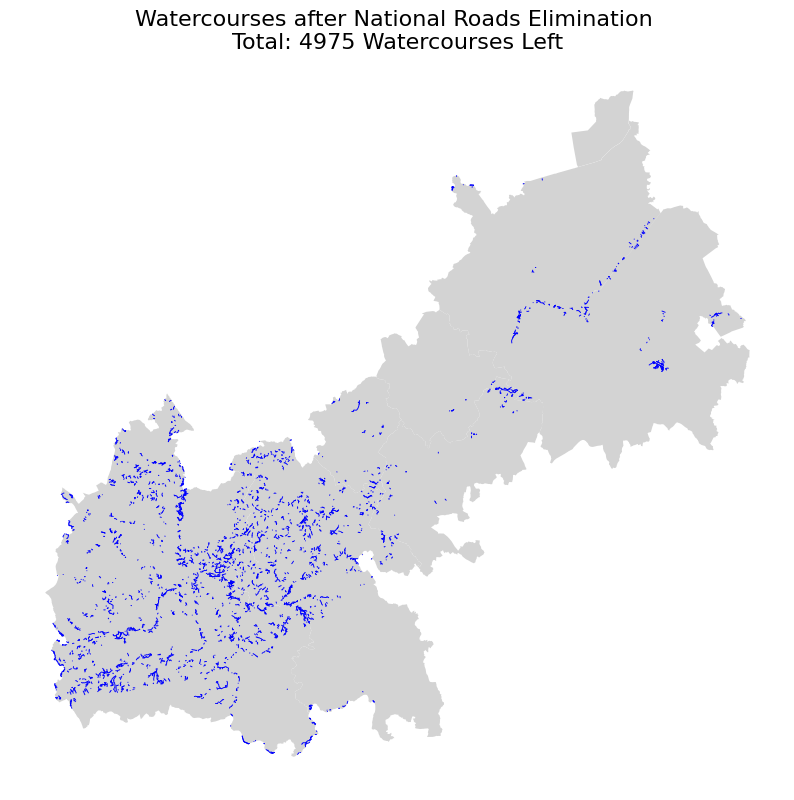

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after National Roads Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Railways

Watercourses within a 100m proximity from railways are eliminated.

In [ ]:
#Load Clipped Rail file
Clip_Rail = gpd.read_file('Clip_Rail.shp')
Clip_Rail.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3975 entries, 0 to 3974
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         3975 non-null   float64 
 1   type       3975 non-null   object  
 2   Intersect  0 non-null      float64 
 3   geometry   3975 non-null   geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 124.3+ KB


In [ ]:
#Spatially join buffered watercourses and rail into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to rail lines
Intersect_water_rail = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Rail, how="inner", predicate='intersects')
Intersect_water_rail.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5189 entries, 251 to 53054
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          5189 non-null   int64   
 1   geometry     5189 non-null   geometry
 2   index_right  5189 non-null   int64   
 3   id           5189 non-null   float64 
 4   type         5189 non-null   object  
 5   Intersect    0 non-null      float64 
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 283.8+ KB


In [ ]:
print("Number of unique FIDs in Intersect_water_rail:", Intersect_water_rail['FID'].nunique())
#This indicates that even if the intersect has 5189 rows, there are actually only 1923 watercourses in proximity of rail lines
#This is caused by mulitple rail lines intersecting with the same watercourses, making them appear several times in the data

Number of unique FIDs in Intersect_water_rail: 1923


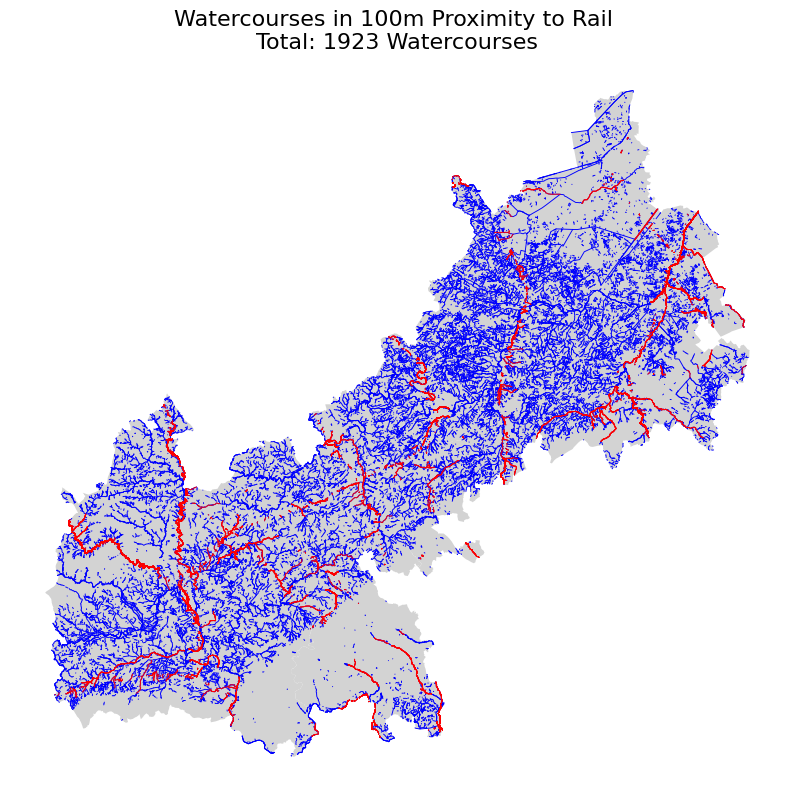

In [ ]:
#Plot watercourses near rail
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_rail.plot(ax=ax, color='red')
num_lines = Intersect_water_rail['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to Rail \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create scoring rail**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Rail lines
#If watercourse near rail (aka is in the intersect dataset) = 0
#If watercourse is not near rail (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_rail['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Rail'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  Score_Rail  
0                    1           1  
1                    1           1  
2                    1           1  
3                    1           1  
4                    1           1

**Create elimination visualization**

In [ ]:
#Keep only the watercourses not near rail lines
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned [~Watercourses_Buffer_cleaned ['FID'].isin(Intersect_water_rail['FID'])]
#Check that there are now 51 387 watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4690 entries, 23 to 52953
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       4690 non-null   int64   
 1   geometry  4690 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 109.9 KB


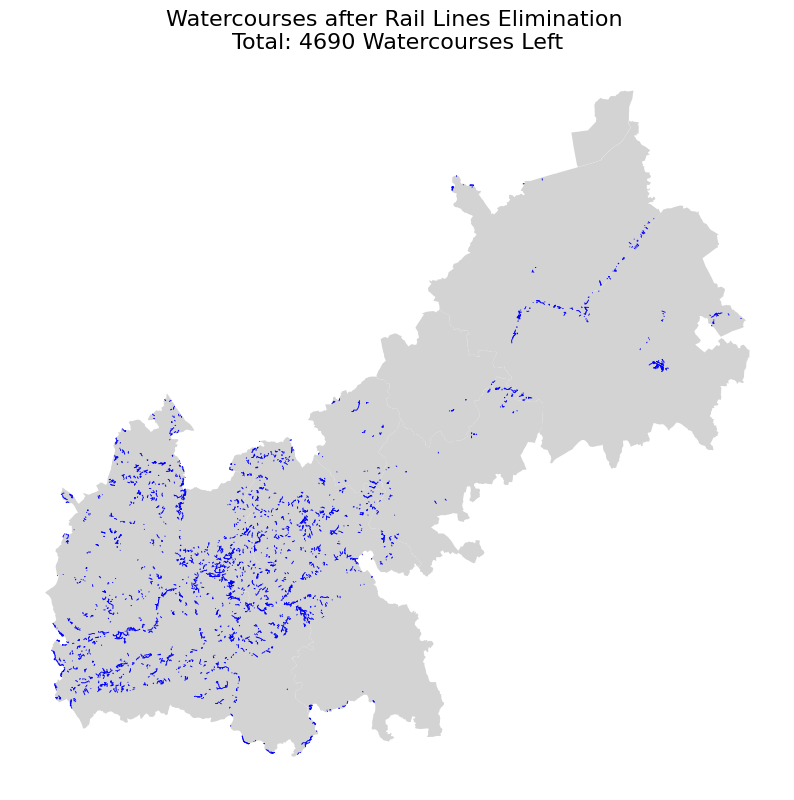

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Rail Lines Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and ETL (pipelines)

Watercourses within a 100m proximity from ETLs are eliminated.

In [ ]:
#Load Clipped ETL file
Clip_ETL = gpd.read_file('Clip_ETL.shp')
Clip_ETL.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         172 non-null    float64 
 1   Intersect  0 non-null      float64 
 2   geometry   172 non-null    geometry
dtypes: float64(2), geometry(1)
memory usage: 4.2 KB


In [ ]:
#Spatially join buffered watercourses and ETL into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to ETL
Intersect_water_ETL = gpd.sjoin(Clip_Watercourses_Buffer, Clip_ETL, how="inner", predicate='intersects')
Intersect_water_ETL.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2230 entries, 771 to 53190
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          2230 non-null   int64   
 1   geometry     2230 non-null   geometry
 2   index_right  2230 non-null   int64   
 3   id           2230 non-null   float64 
 4   Intersect    0 non-null      float64 
dtypes: float64(2), geometry(1), int64(2)
memory usage: 104.5 KB


In [ ]:
print("Number of unique FIDs in Intersect_water_ETL:", Intersect_water_ETL['FID'].nunique())

Number of unique FIDs in Intersect_water_ETL: 1973


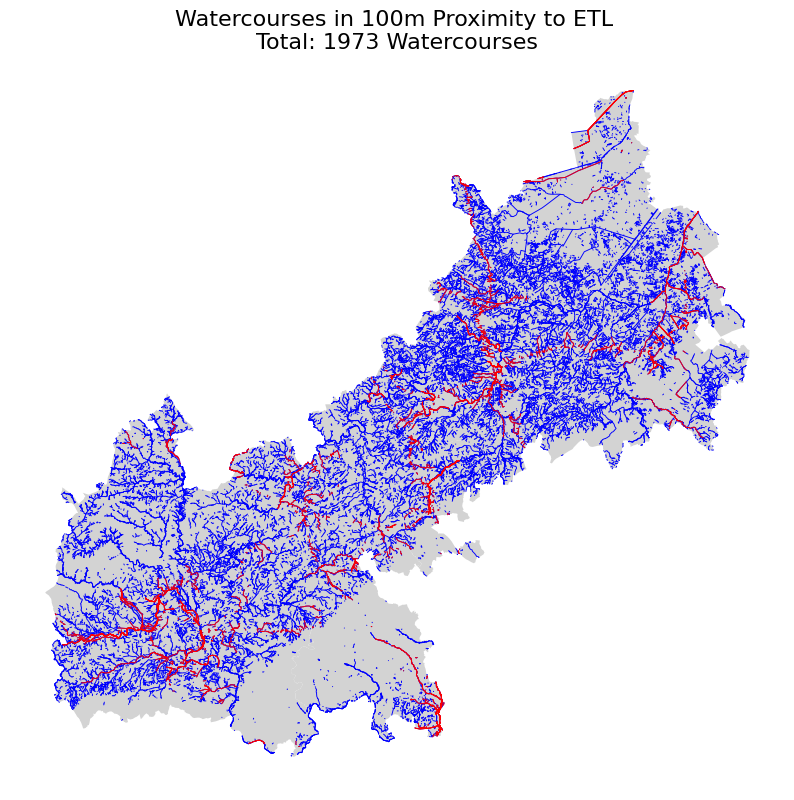

In [ ]:
#Plot watercourses near ETL
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_ETL.plot(ax=ax, color='red')
num_lines = Intersect_water_ETL['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to ETL \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create scoring ETL**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for ETL
#If watercourse near ETL (aka is in the intersect dataset) = 0
#If watercourse is not near ETL (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_ETL['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_ETL'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  Score_Rail  Score_ETL  
0                    1           1          1  
1                    1           1          1  
2                    1           1          1  
3                    1           1          1  
4                    1           1          1

**Create elimination visualization**

In [ ]:
#Keep only the watercourses not near ETL
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[~Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_ETL['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4528 entries, 23 to 52953
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       4528 non-null   int64   
 1   geometry  4528 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 106.1 KB


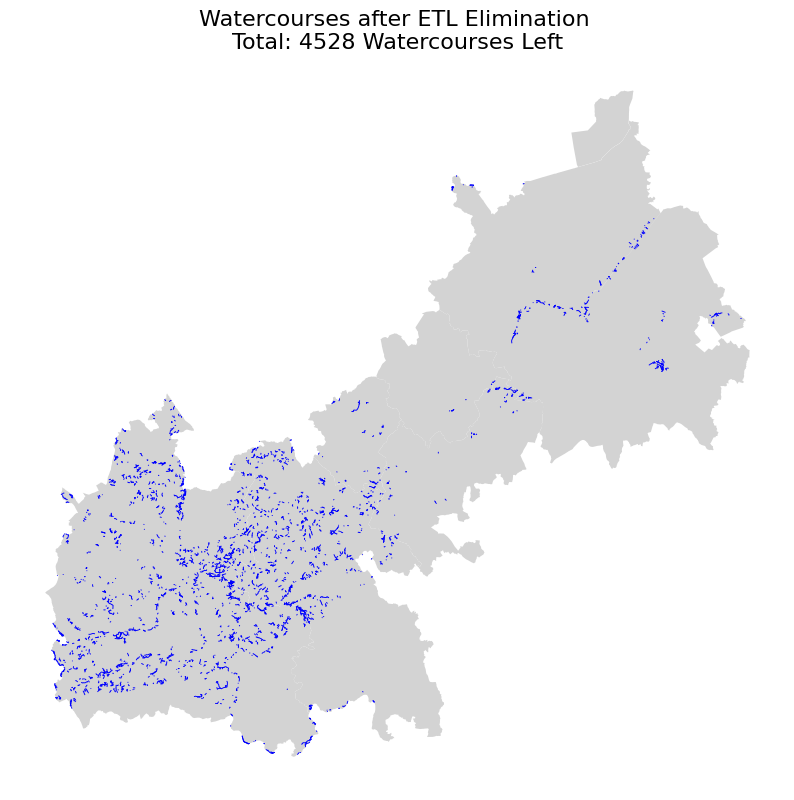

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after ETL Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Protected Areas

Watercourses falling into protected areas are eliminated.

In [ ]:
#Load Clipped Protected Areas file
Clip_Protected_Area = gpd.read_file('Clip_Protected_Area.shp')
Clip_Protected_Area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        40 non-null     float64 
 1   Type      563 non-null    object  
 2   Weight    563 non-null    float64 
 3   geometry  563 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 17.7+ KB


In [ ]:
#Spatially join buffered watercourses and Protected Area into a single dataset
#Allows to indentify which watercourses are within a 100m proximity to Protected Areas
Intersect_water_Pro_Area = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Protected_Area, how="inner", predicate='intersects')
Intersect_water_Pro_Area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5951 entries, 0 to 53234
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          5951 non-null   int64   
 1   geometry     5951 non-null   geometry
 2   index_right  5951 non-null   int64   
 3   id           680 non-null    float64 
 4   Type         5951 non-null   object  
 5   Weight       5951 non-null   float64 
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 325.4+ KB


In [ ]:
print("Number of unique FIDs in Intersect_water_Pro_Area:", Intersect_water_Pro_Area['FID'].nunique())

Number of unique FIDs in Intersect_water_Pro_Area: 4751


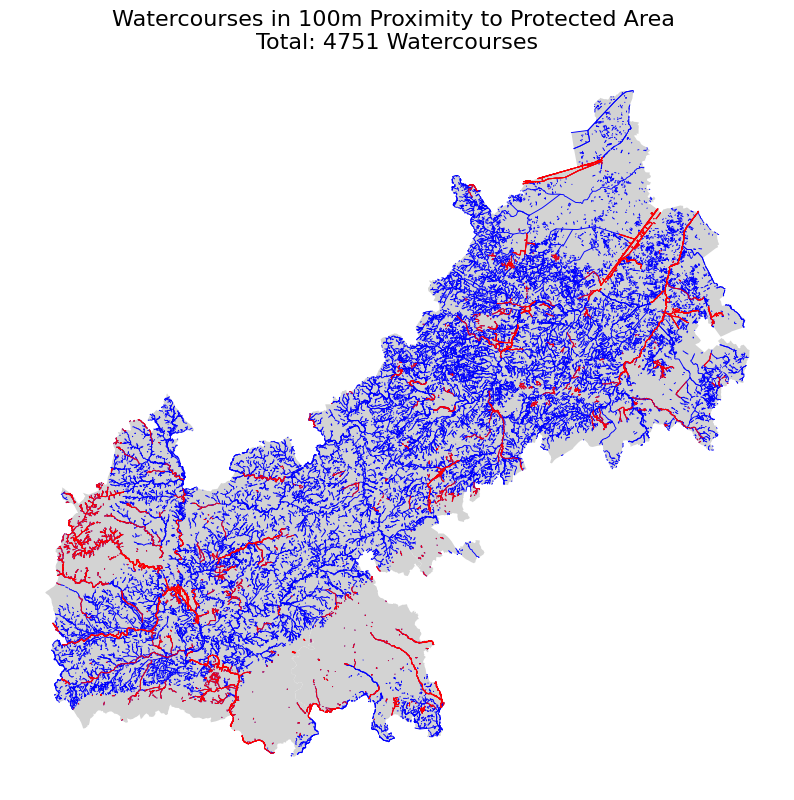

In [ ]:
#Plot watercourses near PA
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_Pro_Area.plot(ax=ax, color='red')
num_lines = Intersect_water_Pro_Area['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to Protected Area \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create scoring protected areas**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Protected Areas (PA)
#If watercourse near PA (aka is in the intersect dataset) = 0
#If watercourse is not near PA (aka is not in intersect dataset) = 1
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_Pro_Area['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Protect_Area'] = Clip_Watercourses['FID'].apply(lambda x: 0 if x in intersect_fids else 1)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  Score_Rail  Score_ETL  Score_Protect_Area  
0                    1           1          1                   1  
1                    1           1          1                   1  
2                    1           1          1                   1  
3                    1           1          1                   1  
4                    1           1          1                   1

**Create elimination visualization**

In [ ]:
#Keep only the watercourses not near Protected Areas
#So keep only the watercourses not in the intersect dataset
Watercourses_Buffer_cleaned = Watercourses_Buffer_cleaned[~Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_Pro_Area['FID'])]
#Check that there are now BLA watercourses left
Watercourses_Buffer_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3913 entries, 23 to 52951
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       3913 non-null   int64   
 1   geometry  3913 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 91.7 KB


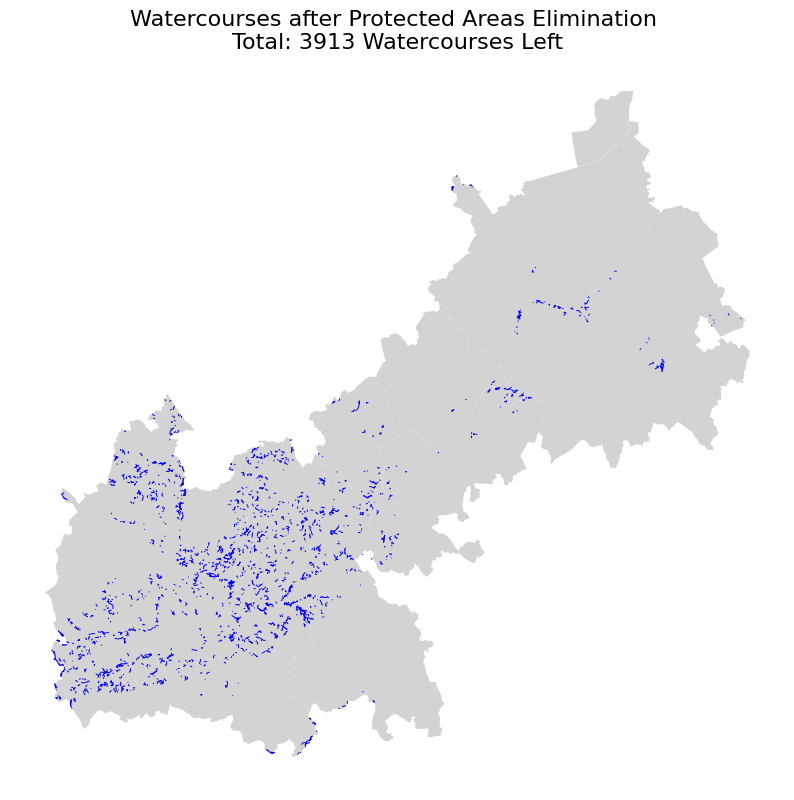

In [ ]:
#Map out watercourses left
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
num_lines = len(Watercourses_Buffer_cleaned) #calculate number of watercourses
ax.set_title(f'Watercourses after Protected Areas Elimination \nTotal: {num_lines} Watercourses Left', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Flood Risk Areas
#UNSURE if we keep only watercourses prone to flooding or not ?
Identify watercourses prone to flood

In [ ]:
#Load Clipped Flood Risk Area file
Clip_Flood_Risk_Area = gpd.read_file('Clip_Flood_Risk_Area.shp')
Clip_Flood_Risk_Area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fra_id      294 non-null    object  
 1   fra_name    294 non-null    object  
 2   frr_cycle   294 non-null    int32   
 3   flood_sour  294 non-null    object  
 4   Weight      294 non-null    int32   
 5   geometry    294 non-null    geometry
dtypes: geometry(1), int32(2), object(3)
memory usage: 11.6+ KB


<Axes: >

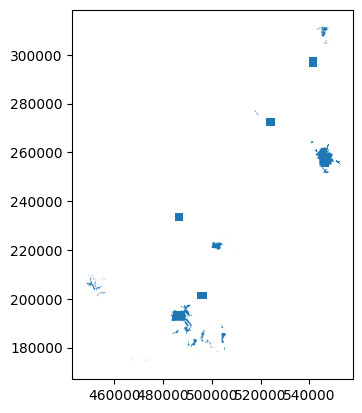

In [ ]:
Clip_Flood_Risk_Area.plot()

In [ ]:
#Spatially join buffered watercourses and Flood Risk into a single dataset
#Allows to indentify which watercourses are within a 100m proximity of Flood Risk Area
Intersect_water_Flood_Risk_Area = gpd.sjoin(Clip_Watercourses_Buffer, Clip_Flood_Risk_Area, how="inner", predicate='intersects')
Intersect_water_Flood_Risk_Area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1428 entries, 5922 to 53186
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          1428 non-null   int64   
 1   geometry     1428 non-null   geometry
 2   index_right  1428 non-null   int64   
 3   fra_id       1428 non-null   object  
 4   fra_name     1428 non-null   object  
 5   frr_cycle    1428 non-null   int32   
 6   flood_sour   1428 non-null   object  
 7   Weight       1428 non-null   int32   
dtypes: geometry(1), int32(2), int64(2), object(3)
memory usage: 89.2+ KB


In [ ]:
print("Number of unique FIDs in Intersect_water_Flood_Risk_Area:", Intersect_water_Flood_Risk_Area['FID'].nunique())

Number of unique FIDs in Intersect_water_Flood_Risk_Area: 1085


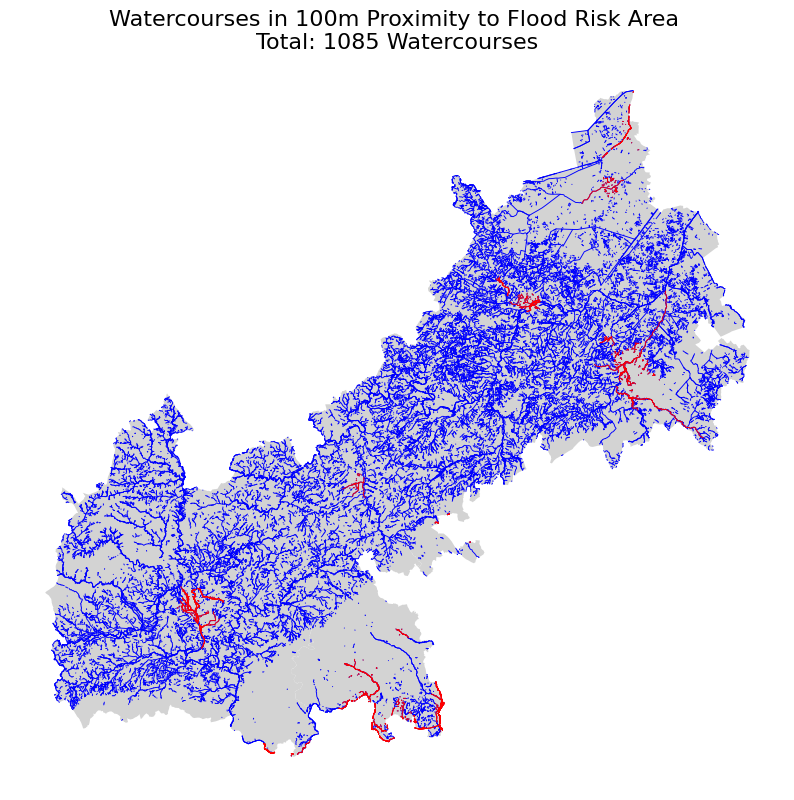

In [ ]:
#Plot watercourses near flood risk area
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Clip_Watercourses_Buffer.plot(ax = ax, color='blue')
Intersect_water_Flood_Risk_Area.plot(ax=ax, color='red')
num_lines = Intersect_water_Flood_Risk_Area['FID'].nunique()
ax.set_title(f'Watercourses in 100m Proximity to Flood Risk Area \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

**Create scoring flood risk areas**

In [ ]:
#Create scoring column in the original watercourses data (not buffered) for Flood Risk Area
#If watercourse near FRA (aka is in the intersect dataset) = 1
#If watercourse is not near FLA (aka is not in intersect dataset) = 0
#Create set of FIDs from the intersect
intersect_fids = set(Intersect_water_Flood_Risk_Area['FID'])
#Assign score of 0 if the FIDs is in intersect, otherwise 1
Clip_Watercourses['Score_Flood_Risk'] = Clip_Watercourses['FID'].apply(lambda x: 1 if x in intersect_fids else 0)
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  Score_Rail  Score_ETL  Score_Protect_Area  \
0                    1           1          1                   1   
1                    1           1          1                   1   
2                    1           1          1                   1   
3                    1           1          1                   1   
4                    1           1          1                   1   

   Score_Flood_Risk  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

**Create elimination visualization**

In [ ]:
#Keep only the watercourses near Flood Risk Areas
#So keep only the watercourses in the intersect dataset
Watercourses_Left_Flood = Watercourses_Buffer_cleaned[Watercourses_Buffer_cleaned['FID'].isin(Intersect_water_Flood_Risk_Area['FID'])]
#Check that there are now 25 watercourses left
Watercourses_Left_Flood.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 25 entries, 6839 to 45629
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       25 non-null     int64   
 1   geometry  25 non-null     geometry
dtypes: geometry(1), int64(1)
memory usage: 600.0 bytes


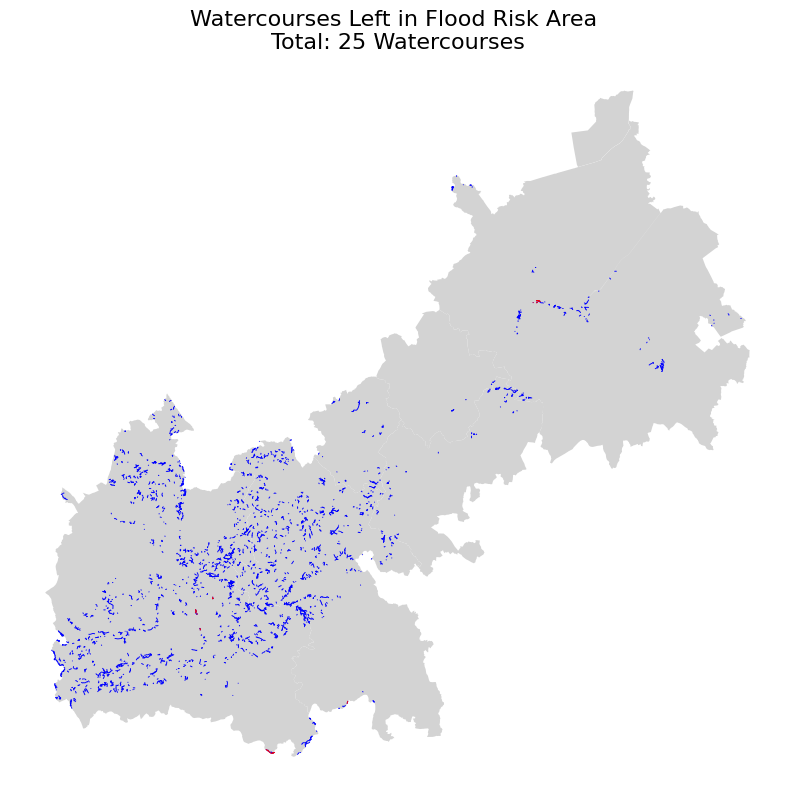

In [ ]:
#Map out to see out of the watercourses left, which fall into flood risk areas
fig, ax = plt.subplots(figsize=(10, 10))
Region.plot(ax=ax, color= 'lightgray')
Watercourses_Buffer_cleaned.plot(ax = ax, color='blue')
Watercourses_Left_Flood.plot(ax=ax, color='red')
num_lines = len(Watercourses_Left_Flood) #calculate number of watercourses
ax.set_title(f'Watercourses Left in Flood Risk Area \nTotal: {num_lines} Watercourses', fontsize=16)
ax.set_axis_off()
plt.show()

# Intersect Watercourses and Contours


In [ ]:
#opening the contour height shapefile
contours = gpd.read_file('Clip_Contours.shp')

In [ ]:
waterbank = Watercourses_Buffer_cleaned.sjoin(contours, how="inner", predicate='intersects')

In [ ]:
waterbank['height'].describe()

count    3338.000000
mean       94.661474
std        37.277227
min        10.000000
25%        70.000000
50%        90.000000
75%       120.000000
max       230.000000
Name: height, dtype: float64

In [ ]:
waterbank.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3338 entries, 23 to 52946
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          3338 non-null   int64   
 1   geometry     3338 non-null   geometry
 2   index_right  3338 non-null   int64   
 3   id           3338 non-null   float64 
 4   type         3338 non-null   object  
 5   height       3338 non-null   float64 
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 182.5+ KB


In [ ]:
waterbank = waterbank[['FID', 'geometry', 'height']]

In [ ]:
waterbank['length'] = waterbank.geometry.length

In [ ]:
#calculating the slope of the river
waterbank['slope'] = waterbank.groupby('FID').apply(lambda x: ((x['height'].max() - x['height'].min()) / x['length'].max()) * 100,
                                                                 include_groups=False)

In [ ]:
waterbank['slope'].describe()

count    3338.000000
mean        0.646019
std         0.994960
min         0.000000
25%         0.000000
50%         0.000000
75%         1.167458
max         4.707812
Name: slope, dtype: float64

In [ ]:
waterbank['slope'].isna().sum()

np.int64(0)

# Saving the Final Datasets

In [ ]:
#Check
Clip_Watercourses.head()

FID   type                                           geometry  \
0  2103927.0  Local  LINESTRING (434121.99 187106.63, 434089.25 187...   
1  2103928.0  Local  LINESTRING (434342.84 187096.15, 434259.2 1870...   
2  2103913.0  Local  LINESTRING (432693.8 187335.4, 432689.51 18736...   
3  2103917.0  Local  LINESTRING (433168.71 187518.53, 433119.03 187...   
4  2103919.0  Local  LINESTRING (433168.71 187518.53, 433172.01 187...   

   Score_Land_Cover  Score_Agri_Value  Score_Road_Local  Score_Road_Regional  \
0                 0                 0                 1                    1   
1                 0                 0                 1                    1   
2                 0                 0                 1                    1   
3                 0                 0                 1                    1   
4                 0                 0                 1                    1   

   Score_Road_National  Score_Rail  Score_ETL  Score_Protect_Area  \
0                    1           1          1                   1   
1                    1           1          1                   1   
2                    1           1          1                   1   
3                    1           1          1                   1   
4                    1           1          1                   1   

   Score_Flood_Risk  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [ ]:
Clip_Watercourses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53310 entries, 0 to 53309
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   FID                  53310 non-null  float64 
 1   type                 53310 non-null  object  
 2   geometry             53310 non-null  geometry
 3   Score_Land_Cover     53310 non-null  int64   
 4   Score_Agri_Value     53310 non-null  int64   
 5   Score_Road_Local     53310 non-null  int64   
 6   Score_Road_Regional  53310 non-null  int64   
 7   Score_Road_National  53310 non-null  int64   
 8   Score_Rail           53310 non-null  int64   
 9   Score_ETL            53310 non-null  int64   
 10  Score_Protect_Area   53310 non-null  int64   
 11  Score_Flood_Risk     53310 non-null  int64   
dtypes: float64(1), geometry(1), int64(9), object(1)
memory usage: 4.9+ MB


In [ ]:
#Convert both 'FID' columns to integers (caused issues when using isin)
Clip_Watercourses['FID'] = Clip_Watercourses['FID'].astype(int)
Watercourses_Buffer_cleaned['FID'] = Watercourses_Buffer_cleaned['FID'].astype(int)

In [ ]:
#Save the overall watercourses dataset with all the scorings
Clip_Watercourses.to_file("Watercourses_Matrix.shp")

<ipython-input-100-a8972c4f1dc4>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Clip_Watercourses.to_file("Watercourses_Matrix.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Land_Cover' to 'Score_Land'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Agri_Value' to 'Score_Agri'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_Local' to 'Score_Road'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_Regional' to 'Score_Ro_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_National' to 'Score_Ro_2'
  ogr_write(
/usr/local/lib/pyt

In [ ]:
#Create dataset containing the 3913 watercourses left after all the elimination (not buffered)
#With the indication of whether or not they fall into flood risk area
Watercourses_Left = Clip_Watercourses[Clip_Watercourses['FID'].isin(Watercourses_Buffer_cleaned['FID'])]
Watercourses_Left.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 70 entries, 2778 to 52960
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   FID                  70 non-null     int64   
 1   type                 70 non-null     object  
 2   geometry             70 non-null     geometry
 3   Score_Land_Cover     70 non-null     int64   
 4   Score_Agri_Value     70 non-null     int64   
 5   Score_Road_Local     70 non-null     int64   
 6   Score_Road_Regional  70 non-null     int64   
 7   Score_Road_National  70 non-null     int64   
 8   Score_Rail           70 non-null     int64   
 9   Score_ETL            70 non-null     int64   
 10  Score_Protect_Area   70 non-null     int64   
 11  Score_Flood_Risk     70 non-null     int64   
dtypes: geometry(1), int64(10), object(1)
memory usage: 7.1+ KB


In [ ]:
#Save the watercourses left after elimination
Watercourses_Left.to_file("Watercourses_Left.shp")

<ipython-input-102-db844d9c2edc>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Watercourses_Left.to_file("Watercourses_Left.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Land_Cover' to 'Score_Land'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Agri_Value' to 'Score_Agri'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_Local' to 'Score_Road'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_Regional' to 'Score_Ro_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Score_Road_National' to 'Score_Ro_2'
  ogr_write(
/usr/local/lib/pytho

In [ ]:
Watercourses_Left_Flood.to_file("Watercourses_Left_Flood.shp")

In [ ]:
Intersect_water_Flood_Risk_Area.to_file('intersect_water_flood_risk_area.shp')

<ipython-input-104-679b303fd3cc>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Intersect_water_Flood_Risk_Area.to_file('intersect_water_flood_risk_area.shp')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


####Sinuosity


In [ ]:
watercourses_left = gpd.read_file('/content/Watercourses_Left.shp')
watercourses_left_flood2 = watercourses_left[watercourses_left['FID'].isin(watercourses_left_flood_risk_area['FID'])]
watercourses_left_flood2.drop(index=841, inplace=True)
def node_by_node_sinuosity(line):
    mylist = []
    start = 0
    coords = list(line.coords)


    if len(coords) < 3:
        return mylist

    for x in range(len(coords) - 2):
        start_node = coords[start]
        end_node = coords[start + 2]

        segment_coords = coords[start:start + 3]
        segment = LineString(segment_coords)
        node_to_node_distance = segment.length

        straight_distance = np.linalg.norm(np.array(start_node) - np.array(end_node))

        node_sinuosity = node_to_node_distance / straight_distance
        mylist.append(node_sinuosity)

        start += 1

    return mylist

NameError: name 'watercourses_left_flood_risk_area' is not defined

In [ ]:
def add_segments_to_df(line):
  seglist = []
  start = 0
  coords = list(line.coords)


  if len(coords) < 3:
      return seglist

  for x in range(len(coords) - 2):
      start_node = coords[start]
      end_node = coords[start + 2]

      segment_coords = coords[start:start + 3]
      segment = LineString(segment_coords)
      seglist.append(segment)
  return seglist

In [ ]:
watercourses_left_flood2['node_sinuosity'] = watercourses_left_flood2['geometry'].apply(node_by_node_sinuosity)
watercourses_left_flood2['coords_per_each'] = watercourses_left_flood2['geometry'].apply(add_segments_to_df)

In [ ]:
watercourses_node_by_node_sinuosity = watercourses_left_flood2.explode('coords_per_each').reset_index(drop=True)
watercourses_node_by_node_sinuosity=watercourses_left_flood2.explode('node_sinuosity')

In [ ]:
fig, ax = plt.subplots(1)
watercourses_node_by_node_sinuosity.plot('node_sinuosity', ax=ax, alpha=0.3)
ax.set_xlim(left=450000, right=454000)
ax.set_ylim(bottom=200000, top=202000)
cx.add_basemap(ax=ax, crs='epsg:27700')


In [ ]:
fig, ax = plt.subplots(1)
casestudy_oxford.plot('node_sinuosity', ax=ax, alpha=0.3)

cx.add_basemap( ax=ax, crs='epsg:27700')